In [2]:
print("g")

g


In [3]:
import os
import cv2
import numpy as np
import pillow_heif                     # HEIC/HEIF support
pillow_heif.register_heif_opener()     # Enable HEIC for PIL
from PIL import Image
from sklearn.cluster import DBSCAN
import pickle
import insightface
from insightface.app import FaceAnalysis


SUPPORTED_EXTS = ('.jpg', '.jpeg', '.png', '.heic', '.bmp', '.tiff', '.webp', '.gif')

# Initialize ArcFace model/app
app = FaceAnalysis(name='antelopev2', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

IMAGE_FOLDER = '/Users/pranjalgarg/Desktop/test_image_recogo/dataset'
EXPORT_DIR = '/Users/pranjalgarg/Desktop/test_image_recogo/arcface_clusters_export'
os.makedirs(EXPORT_DIR, exist_ok=True)

color_map = [
    (0,0,255), (0,255,0), (255,0,0), (0,165,255), (128,0,128), (255,255,0),
    (255,0,255), (203,192,255), (0,255,255), (50,205,50), (255,255,240), (128,128,128)
]

def get_color(idx):
    return color_map[idx % len(color_map)] if idx != -1 else (0,0,0)

def load_images(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if f.lower().endswith(SUPPORTED_EXTS)]

embeddings = []
face_infos = []
img_paths = load_images(IMAGE_FOLDER)
print(f"Loaded {len(img_paths)} images.")

# --------- Embedding extraction ----------
for img_path in img_paths:
    try:
        img_pil = Image.open(img_path)
        img = np.array(img_pil)

        # Handle grayscale / RGBA
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        # Convert RGB (PIL) -> BGR (OpenCV/InsightFace)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    except Exception as e:
        print(f"Could not load {img_path}: {e}")
        continue

    faces = app.get(img)
    for face in faces:
        embeddings.append(face.embedding)
        bbox = face.bbox.astype(int)
        face_infos.append({
            'img_path': img_path,
            'bbox': bbox,
            'embedding_idx': len(embeddings) - 1,
            'embedding': face.embedding
        })

embeddings = np.array(embeddings)
print(f"Extracted {len(embeddings)} face embeddings.")

# --------- Clustering ----------
eps = 0.35
db = DBSCAN(eps=eps, min_samples=2, metric='cosine')
labels = db.fit_predict(embeddings)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Clusters found: {n_clusters}, Noise faces: {(labels == -1).sum()}')

# --------- Cluster-wise export ----------
cluster_map = {}
for info, label in zip(face_infos, labels):
    cluster_map.setdefault(label, []).append(info)

for clus_id, infos in cluster_map.items():
    clus_name = f"cluster_{clus_id}" if clus_id != -1 else "noise"
    clus_folder = os.path.join(EXPORT_DIR, clus_name)
    os.makedirs(clus_folder, exist_ok=True)

    img_face_map = {}
    for info in infos:
        img_face_map.setdefault(info['img_path'], []).append(info['bbox'])

    for img_path, bboxes in img_face_map.items():
        try:
            img_pil = Image.open(img_path)
            img = np.array(img_pil)

            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

            # RGB -> BGR before drawing and saving
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        except Exception as e:
            print(f"Could not load {img_path} for marking: {e}")
            continue

        color = get_color(clus_id)
        for box in bboxes:
            x1, y1, x2, y2 = box
            cluster_label = f'Cluster {clus_id}' if clus_id != -1 else "Noise"
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(
                img, cluster_label, (x1, y1-12),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA
            )

        out_base = os.path.splitext(os.path.basename(img_path))[0]
        out_path = os.path.join(clus_folder, out_base + ".png")
        cv2.imwrite(out_path, img)

print(f"Cluster-wise folders with marked images saved to {EXPORT_DIR}!")

# --------- Save face info for later search ----------
faceinfos_to_save = []
for info, label in zip(face_infos, labels):
    faceinfos_to_save.append({
        'img_path': info['img_path'],
        'embedding': info['embedding'],
        'cluster_label': label,
        'bbox': info['bbox'].tolist()
    })

with open("faceinfos.pkl", "wb") as f:
    pickle.dump(faceinfos_to_save, f)

print("Saved faceinfos.pkl for search!")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/pranjalgarg/.insightface/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/pranjalgarg/.insightface/models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/pranjalgarg/.insightface/models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/pranjalgarg/.insightface/models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/pranjalgarg/.insightface/models/antelopev2/scrfd_10g_bnkps.onn

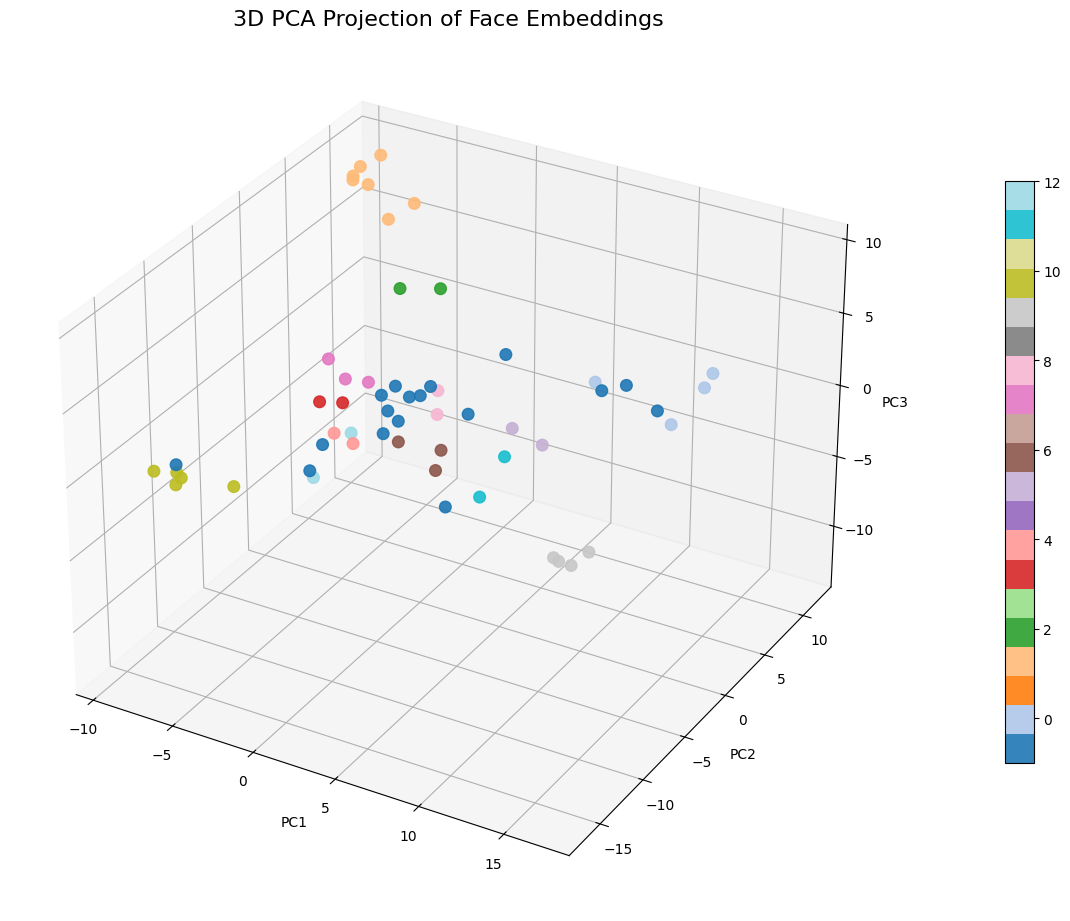

In [10]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
pca3_result = pca3.fit_transform(embeddings)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    pca3_result[:,0], pca3_result[:,1], pca3_result[:,2],
    c=labels, cmap='tab20', s=70, alpha=0.9
)

plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
ax.set_title("3D PCA Projection of Face Embeddings", fontsize=16)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()


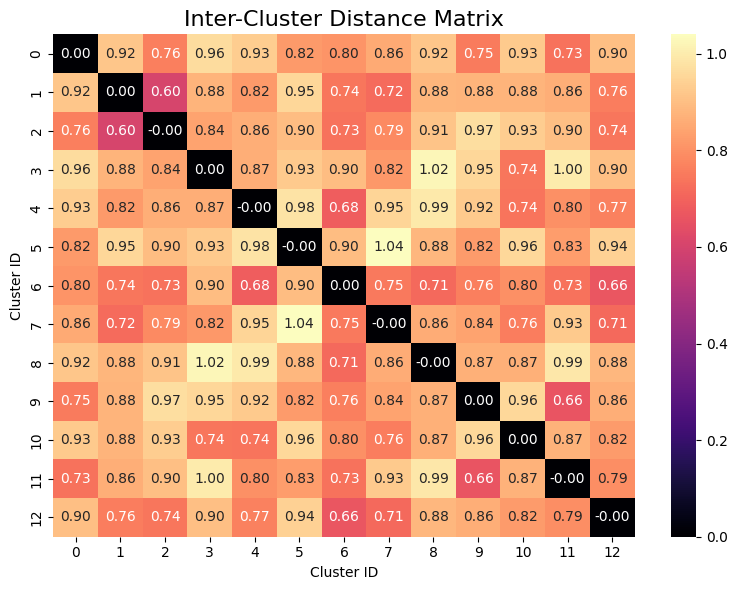

In [14]:
cluster_ids = [c for c in set(labels) if c != -1]

centroids = []
for cid in cluster_ids:
    cluster_embeds = embeddings[labels == cid]
    centroids.append(cluster_embeds.mean(axis=0))

centroids = np.vstack(centroids)

cluster_dist = 1 - cosine_similarity(centroids)

plt.figure(figsize=(8,6))
sns.heatmap(
    cluster_dist, annot=True, fmt=".2f", cmap="magma",
    xticklabels=cluster_ids, yticklabels=cluster_ids
)

plt.title("Inter-Cluster Distance Matrix", fontsize=16)
plt.xlabel("Cluster ID")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()


Using image: /Users/pranjalgarg/Desktop/test_image_recogo/dataset/WhatsApp Image 2025-11-27 at 21.10.18.jpeg


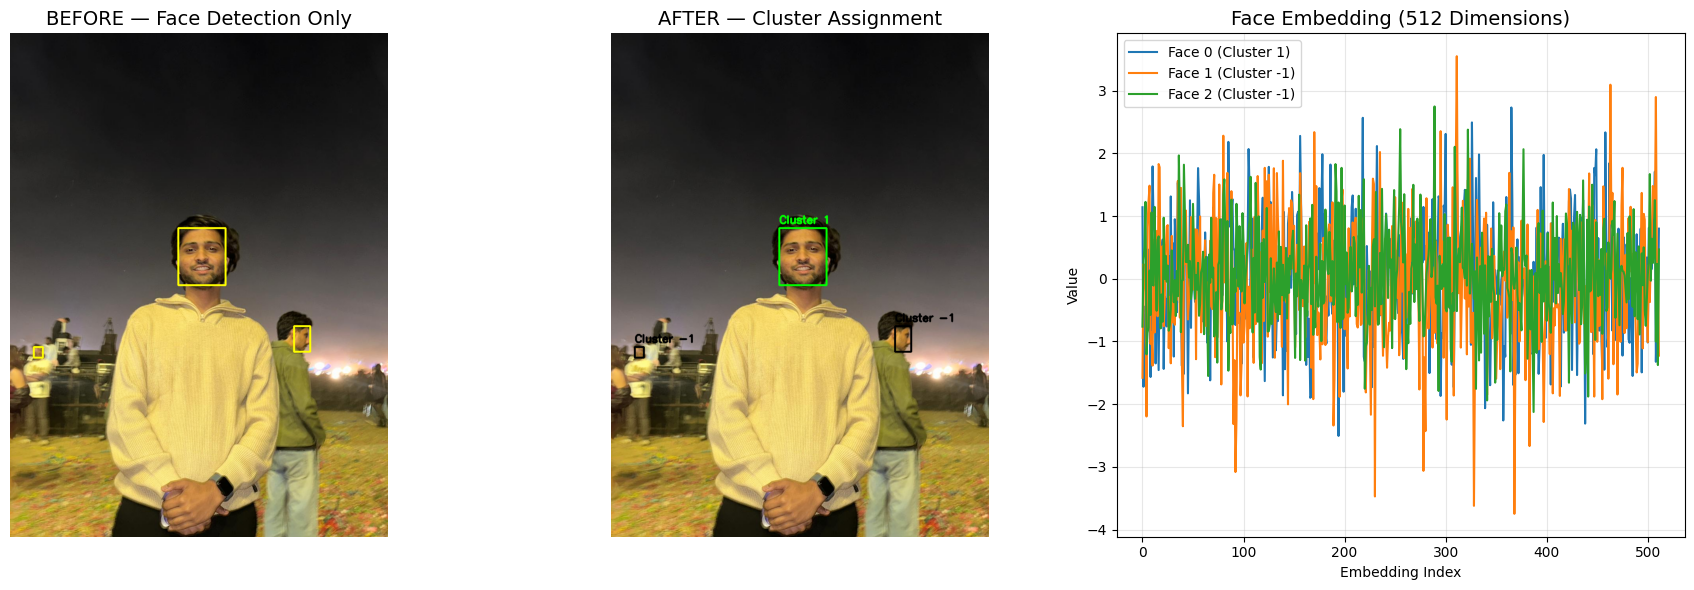

In [18]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# -------- SELECT ONE IMAGE BY FILENAME ONLY --------
TARGET_FILENAME = "WhatsApp Image 2025-11-27 at 21.10.18.jpeg"

# -------- FIND ALL FACES FOR THIS IMAGE --------
faces_for_this_image = []
actual_path = None

for info, label in zip(face_infos, labels):
    if os.path.basename(info["img_path"]) == TARGET_FILENAME:
        actual_path = info["img_path"]
        faces_for_this_image.append({
            "bbox": info["bbox"],
            "embedding": info["embedding"],
            "label": label
        })

if actual_path is None:
    print("⚠️ ERROR: Filename not found. Check EXACT spelling including extension.")
    raise SystemExit

if len(faces_for_this_image) == 0:
    print("⚠️ ERROR: No faces detected for this image!")
    raise SystemExit

print("Using image:", actual_path)

# -------- LOAD IMAGE --------
img_pil = Image.open(actual_path)
img = np.array(img_pil)

# Fix grayscale or alpha channels
if img.ndim == 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
elif img.shape[2] == 4:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# -------- BEFORE (just detection rectangles) --------
before_img = img_bgr.copy()
for face in faces_for_this_image:
    x1, y1, x2, y2 = face["bbox"]
    cv2.rectangle(before_img, (x1, y1), (x2, y2), (0,255,255), 4)

# -------- AFTER (cluster-colored rectangles) --------
after_img = img_bgr.copy()

def get_color(idx):
    color_map = [
        (0,0,255), (0,255,0), (255,0,0), (0,165,255), (128,0,128),
        (255,255,0), (255,0,255), (203,192,255), (0,255,255),
        (50,205,50), (255,255,240), (128,128,128)
    ]
    return color_map[idx % len(color_map)] if idx != -1 else (0,0,0)

for face in faces_for_this_image:
    x1, y1, x2, y2 = face["bbox"]
    cl = face["label"]
    color = get_color(cl)
    cv2.rectangle(after_img, (x1, y1), (x2, y2), color, 4)
    cv2.putText(after_img, f"Cluster {cl}", (x1, y1-12),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3)

# -------- PLOT EVERYTHING --------

plt.figure(figsize=(18,6))

# BEFORE
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB))
plt.title("BEFORE — Face Detection Only", fontsize=14)
plt.axis("off")

# AFTER
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB))
plt.title("AFTER — Cluster Assignment", fontsize=14)
plt.axis("off")

# EMBEDDING VECTOR
plt.subplot(1,3,3)
for i, face in enumerate(faces_for_this_image):
    emb = face["embedding"]
    plt.plot(emb, label=f"Face {i} (Cluster {face['label']})")

plt.title("Face Embedding (512 Dimensions)", fontsize=14)
plt.xlabel("Embedding Index")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


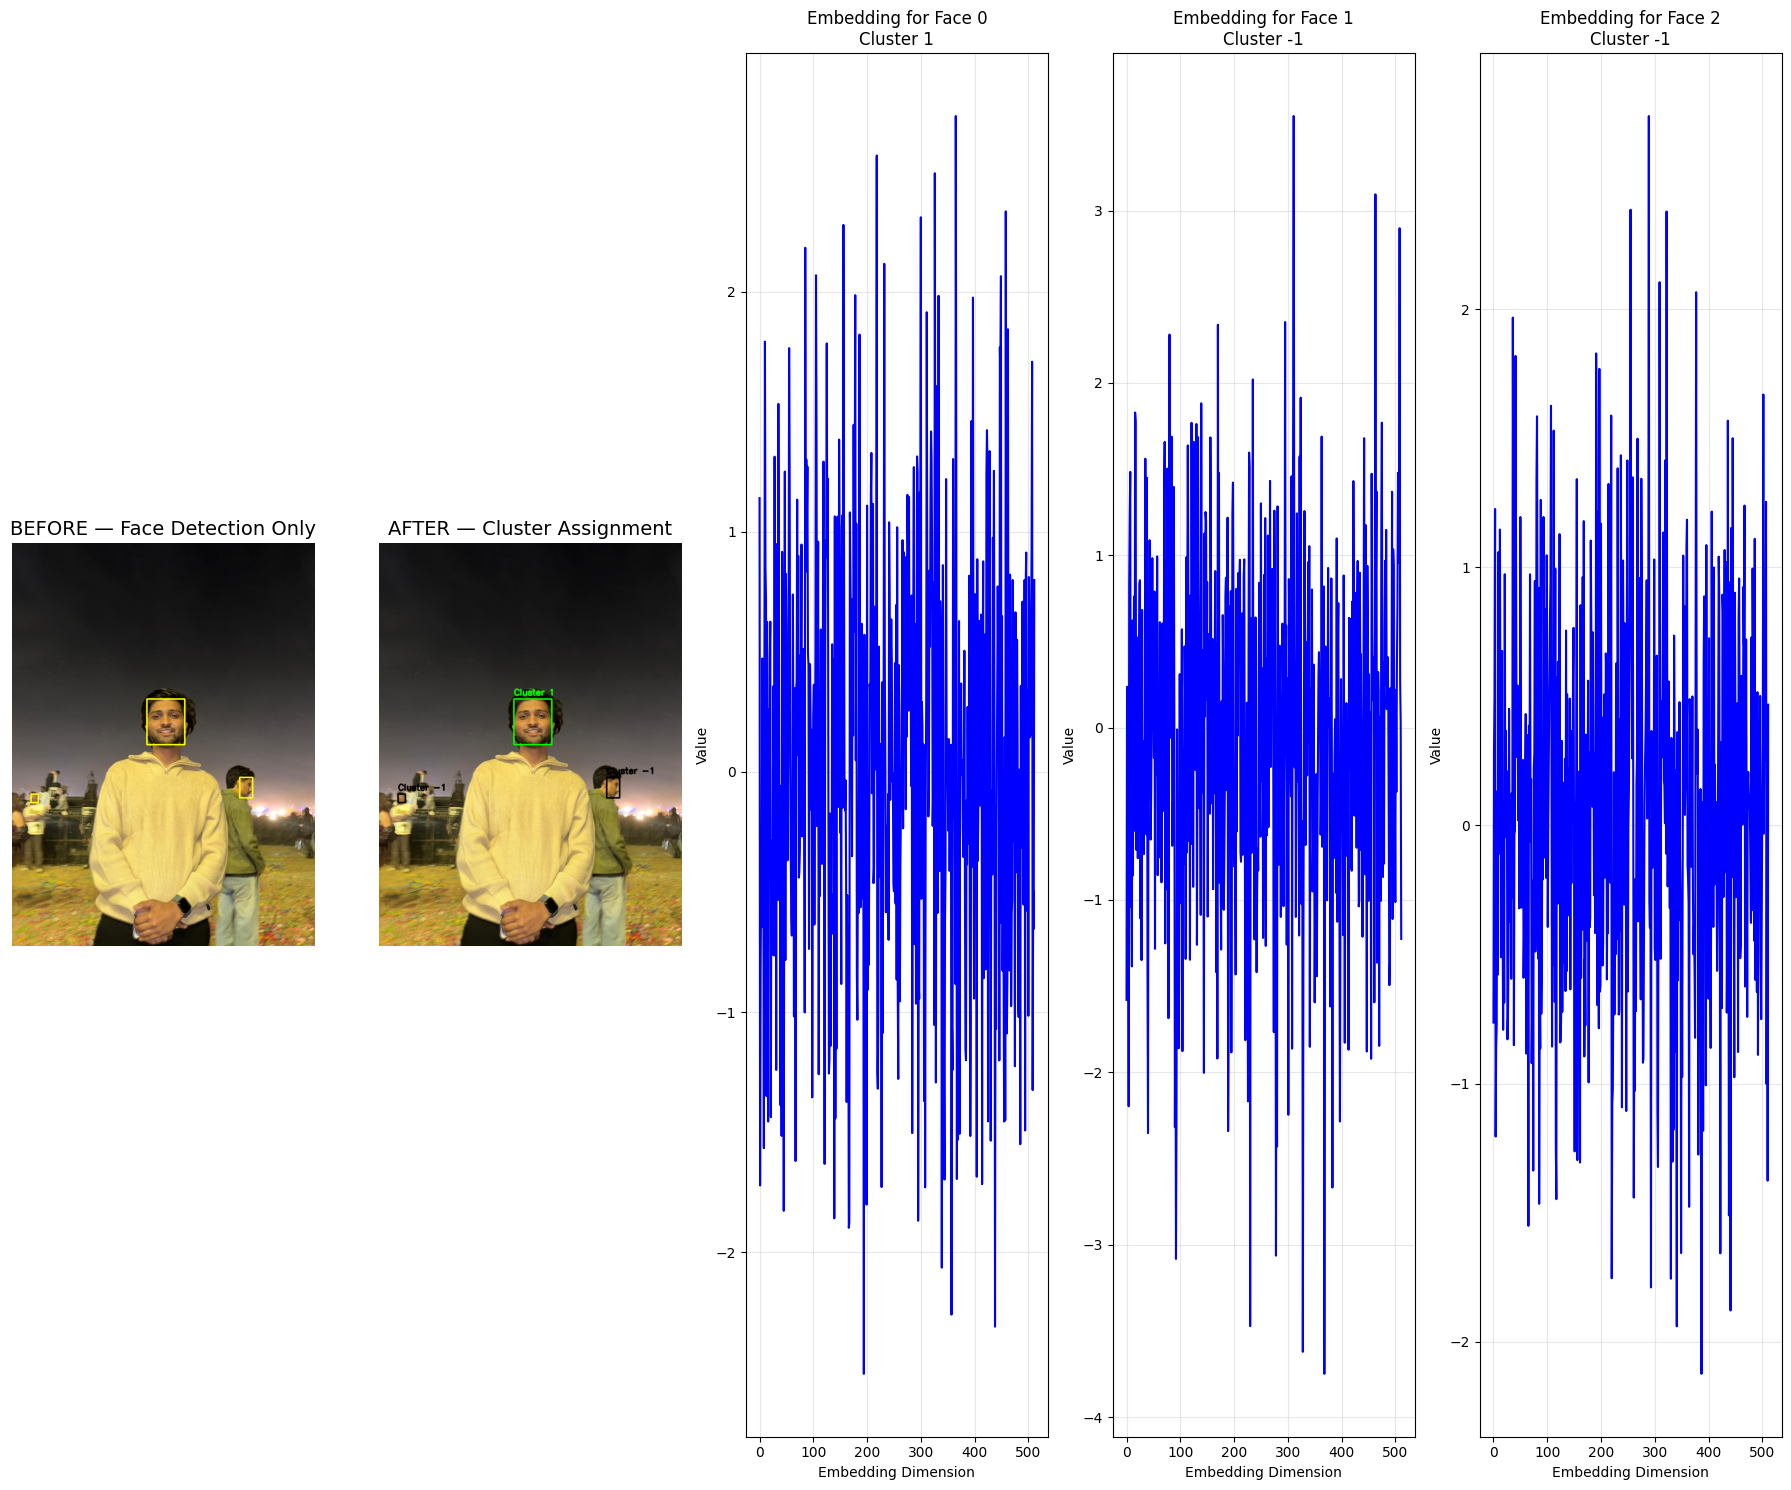

In [19]:
# -------- PLOT EVERYTHING --------

num_faces = len(faces_for_this_image)

plt.figure(figsize=(18, 6 + 3*num_faces))

# BEFORE
plt.subplot(1, num_faces+2, 1)
plt.imshow(cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB))
plt.title("BEFORE — Face Detection Only", fontsize=14)
plt.axis("off")

# AFTER
plt.subplot(1, num_faces+2, 2)
plt.imshow(cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB))
plt.title("AFTER — Cluster Assignment", fontsize=14)
plt.axis("off")

# INDIVIDUAL EMBEDDING GRAPHS
start_idx = 3
for i, face in enumerate(faces_for_this_image):
    emb = face["embedding"]
    plt.subplot(1, num_faces+2, start_idx + i)
    plt.plot(emb, color="blue")
    plt.title(f"Embedding for Face {i}\nCluster {face['label']}", fontsize=12)
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



Cosine Similarity Matrix (Faces in this Image):

[[ 0.9999995  -0.00204097  0.00273751]
 [-0.00204097  0.9999997   0.10205843]
 [ 0.00273751  0.10205843  1.        ]]


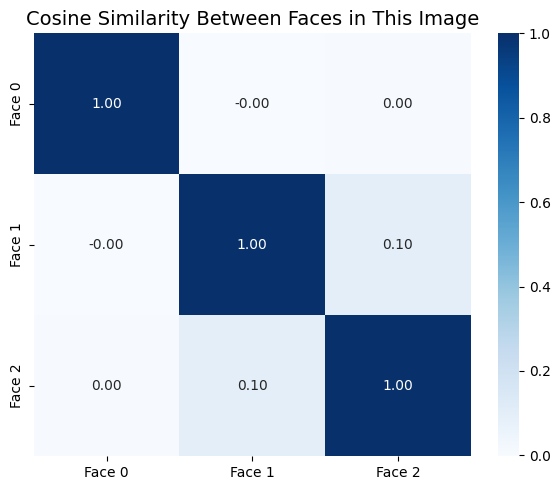

In [20]:
# -------- COSINE SIMILARITY BETWEEN FACES IN THIS IMAGE --------
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Build embedding matrix for this image only
emb_matrix = np.vstack([f["embedding"] for f in faces_for_this_image])

# Compute cosine similarity matrix
cos_sim = cosine_similarity(emb_matrix)

print("\nCosine Similarity Matrix (Faces in this Image):\n")
print(cos_sim)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    cos_sim, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=[f"Face {i}" for i in range(len(faces_for_this_image))],
    yticklabels=[f"Face {i}" for i in range(len(faces_for_this_image))]
)
plt.title("Cosine Similarity Between Faces in This Image", fontsize=14)
plt.tight_layout()
plt.show()


Total faces in Cluster 1: 7

Cosine Similarity Matrix for Cluster 1:

[[0.9999998  0.6447905  0.6366379  0.65120476 0.67663264 0.68520373
  0.6390047 ]
 [0.6447905  1.0000006  0.78040403 0.84244937 0.7820592  0.7316214
  0.94961303]
 [0.6366379  0.78040403 0.9999995  0.81845015 0.87851256 0.6792442
  0.82228756]
 [0.65120476 0.84244937 0.81845015 1.         0.83812577 0.7956229
  0.8635174 ]
 [0.67663264 0.7820592  0.87851256 0.83812577 0.99999994 0.7189824
  0.80226433]
 [0.68520373 0.7316214  0.6792442  0.7956229  0.7189824  1.0000001
  0.72780204]
 [0.6390047  0.94961303 0.82228756 0.8635174  0.80226433 0.72780204
  1.0000002 ]]


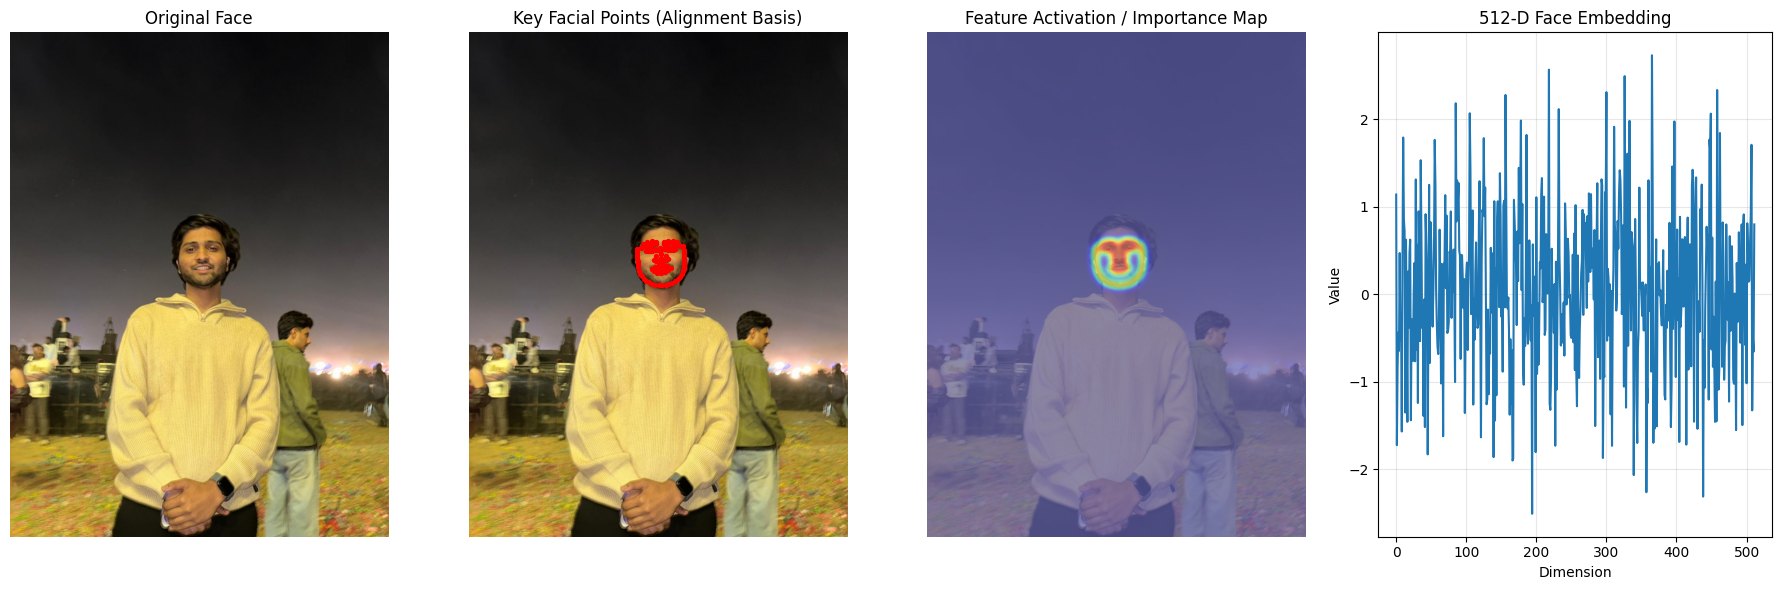

In [47]:
# -------- Extract all faces belonging to Cluster 1 --------
cluster_id = 1   # the cluster you want
cluster_faces = []

for info, label in zip(face_infos, labels):
    if label == cluster_id:
        cluster_faces.append({
            "img_path": info["img_path"],
            "embedding": info["embedding"],
            "bbox": info["bbox"]
        })

print(f"Total faces in Cluster {cluster_id}: {len(cluster_faces)}")

if len(cluster_faces) < 2:
    print("Not enough faces to compute correlation matrix.")
    raise SystemExit
# -------- Build embedding matrix --------
cluster_emb_matrix = np.vstack([f["embedding"] for f in cluster_faces])
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_cluster = cosine_similarity(cluster_emb_matrix)

print("\nCosine Similarity Matrix for Cluster 1:\n")
print(cos_sim_cluster)
from insightface.app import FaceAnalysis
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

TARGET_FILENAME = "WhatsApp Image 2025-11-27 at 21.10.18.jpeg"

# Find the face object with bbox, embedding, landmark points
target_face = None
actual_path = None

for info, label in zip(face_infos, labels):
    if os.path.basename(info["img_path"]) == TARGET_FILENAME:
        actual_path = info["img_path"]
        target_face = info
        break

img = cv2.imread(actual_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# detect faces again to get aligned face
faces = app.get(img)
face = faces[0]

aligned = face.normed_embedding.reshape(512)
# Create a visual "feature activation map" from face landmarks
landmarks = face.landmark_2d_106

feature_map = np.zeros((img.shape[0], img.shape[1]))
for (x,y) in landmarks.astype(int):
    cv2.circle(feature_map, (x,y), 8, 255, -1)

feature_map = cv2.GaussianBlur(feature_map, (55,55), 0)
feature_map = cv2.normalize(feature_map, None, 0, 255, cv2.NORM_MINMAX)
# Plot 4-panel visualization
plt.figure(figsize=(18,6))

# Panel 1 — Original Face
plt.subplot(1,4,1)
plt.imshow(img_rgb)
plt.title("Original Face")
plt.axis("off")

# Panel 2 — Face Landmarks / Alignment
plt.subplot(1,4,2)
plt.imshow(img_rgb)
plt.scatter(landmarks[:,0], landmarks[:,1], s=8, c='red')
plt.title("Key Facial Points (Alignment Basis)")
plt.axis("off")

# Panel 3 — Feature Importance Map
plt.subplot(1,4,3)
plt.imshow(img_rgb, alpha=0.5)
plt.imshow(feature_map, cmap="jet", alpha=0.45)
plt.title("Feature Activation / Importance Map")
plt.axis("off")

# Panel 4 — 512-D Embedding
plt.subplot(1,4,4)
plt.plot(face.embedding)
plt.title("512-D Face Embedding")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()




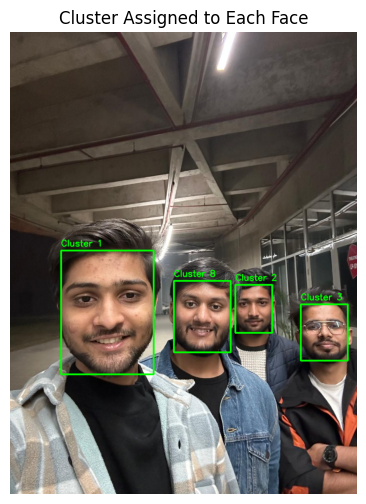

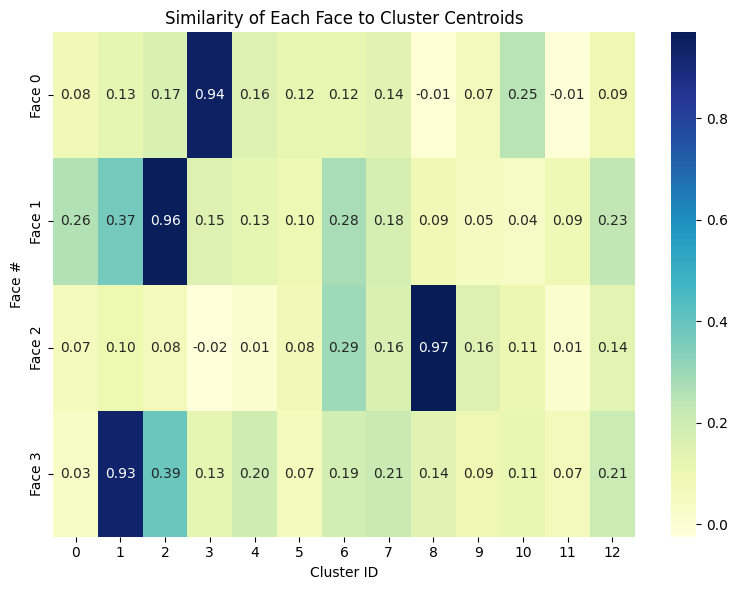

In [46]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# SELECT TARGET IMAGE
# ============================================================

TARGET_FILENAME = "WhatsApp Image 2025-11-27 at 21.13.26 (3).jpeg"

# ============================================================
# EXTRACT ALL FACES FROM SELECTED IMAGE
# ============================================================

faces_this_image = []
actual_path = None

for info, label in zip(face_infos, labels):
    if os.path.basename(info["img_path"]) == TARGET_FILENAME:
        faces_this_image.append({
            "embedding": info["embedding"],
            "bbox": info["bbox"],
            "cluster": label
        })
        actual_path = info["img_path"]

if actual_path is None:
    raise ValueError("Image not found. Check filename EXACTLY.")

img = cv2.imread(actual_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ============================================================
# GRAPH 2 — CLUSTER ASSIGNED TO EACH FACE (GREEN BOXES)
# ============================================================

plt.figure(figsize=(12,6))
vis2 = img_rgb.copy()

for i, f in enumerate(faces_this_image):
    x1, y1, x2, y2 = f["bbox"]
    cl = f["cluster"]

    # --- GREEN Bounding Box + Label ---
    cv2.rectangle(vis2, (x1, y1), (x2, y2), (0,255,0), 3)  # GREEN box
    cv2.putText(
        vis2,
        f"Cluster {cl}",
        (x1, y1-12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0,255,0),  # GREEN text
        2
    )

plt.imshow(vis2)
plt.title("Cluster Assigned to Each Face")
plt.axis("off")
plt.show()

# ============================================================
# GRAPH 3 — SIMILARITY OF EACH FACE TO ALL CLUSTER CENTROIDS
# ============================================================

# Build cluster centroids (ignore noise = -1)
unique_clusters = sorted(list(set(labels)))
cluster_centroids = {}

for cid in unique_clusters:
    if cid == -1:
        continue
    cluster_embs = np.vstack([
        info["embedding"]
        for info, lab in zip(face_infos, labels)
        if lab == cid
    ])
    cluster_centroids[cid] = cluster_embs.mean(axis=0)

# Build similarity table
similarity_table = []
for f in faces_this_image:
    row = {}
    for cid, centroid in cluster_centroids.items():
        sim = cosine_similarity(
            f["embedding"].reshape(1,-1),
            centroid.reshape(1,-1)
        )[0][0]
        row[cid] = sim
    similarity_table.append(row)

# Convert to DataFrame
df = pd.DataFrame(similarity_table)
df.index = [f"Face {i}" for i in range(len(faces_this_image))]

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Similarity of Each Face to Cluster Centroids")
plt.xlabel("Cluster ID")
plt.ylabel("Face #")
plt.tight_layout()
plt.show()


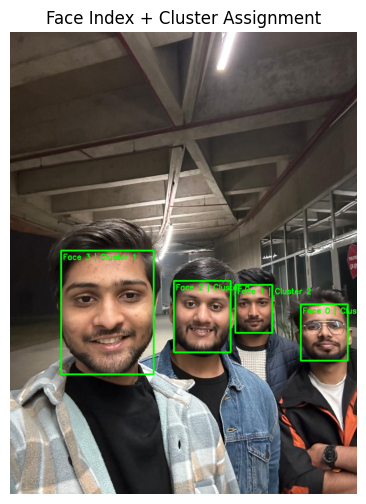

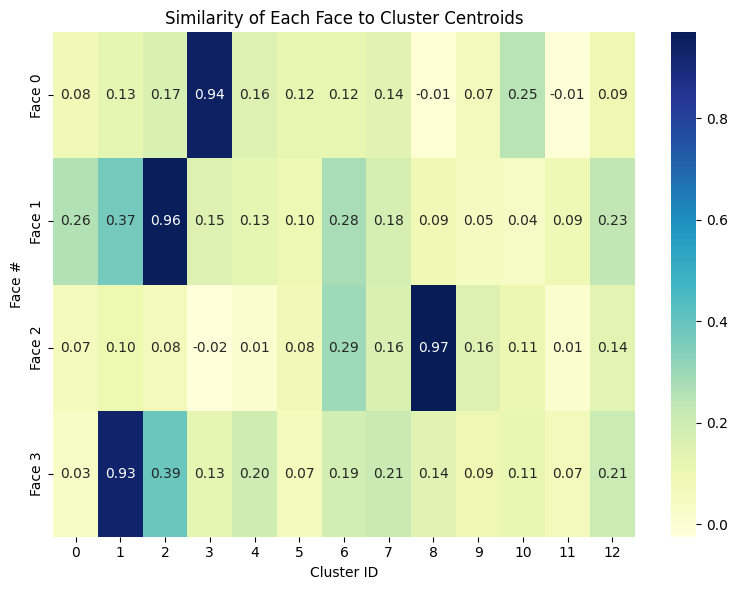

In [49]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# SELECT TARGET IMAGE
# ============================================================

TARGET_FILENAME = "WhatsApp Image 2025-11-27 at 21.13.26 (3).jpeg"

# ============================================================
# EXTRACT ALL FACES FROM SELECTED IMAGE
# ============================================================

faces_this_image = []
actual_path = None

for info, label in zip(face_infos, labels):
    if os.path.basename(info["img_path"]) == TARGET_FILENAME:
        faces_this_image.append({
            "embedding": info["embedding"],
            "bbox": info["bbox"],
            "cluster": label
        })
        actual_path = info["img_path"]

if actual_path is None:
    raise ValueError("Image not found. Check filename EXACTLY.")

img = cv2.imread(actual_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ============================================================
# GRAPH 2 — FACE NUMBER + CLUSTER NAME INSIDE GREEN BOX
# ============================================================

plt.figure(figsize=(12,6))
vis2 = img_rgb.copy()

for i, f in enumerate(faces_this_image):
    x1, y1, x2, y2 = f["bbox"]
    cl = f["cluster"]

    # Label text
    label_text = f"Face {i} | Cluster {cl}"

    # GREEN bounding box
    cv2.rectangle(vis2, (x1, y1), (x2, y2), (0,255,0), 3)

    # Text INSIDE the box (top-left corner inside)
    text_x = x1 + 5
    text_y = y1 + 25  # inside the box for readability

    cv2.putText(
        vis2,
        label_text,
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0,255,0),
        2
    )

plt.imshow(vis2)
plt.title("Face Index + Cluster Assignment")
plt.axis("off")
plt.show()

# ============================================================
# GRAPH 3 — SIMILARITY OF EACH FACE TO ALL CLUSTER CENTROIDS
# ============================================================

# Build centroids for each cluster (ignore noise = -1)
unique_clusters = sorted(list(set(labels)))
cluster_centroids = {}

for cid in unique_clusters:
    if cid == -1:
        continue
    cluster_embs = np.vstack([
        info["embedding"]
        for info, lab in zip(face_infos, labels)
        if lab == cid
    ])
    cluster_centroids[cid] = cluster_embs.mean(axis=0)

# Build similarity table (face vs each cluster centroid)
similarity_table = []
for f in faces_this_image:
    row = {}
    for cid, centroid in cluster_centroids.items():
        sim = cosine_similarity(
            f["embedding"].reshape(1,-1),
            centroid.reshape(1,-1)
        )[0][0]
        row[cid] = sim
    similarity_table.append(row)

# Convert to DataFrame for heatmap
df = pd.DataFrame(similarity_table)
df.index = [f"Face {i}" for i in range(len(faces_this_image))]

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Similarity of Each Face to Cluster Centroids")
plt.xlabel("Cluster ID")
plt.ylabel("Face #")
plt.tight_layout()
plt.show()


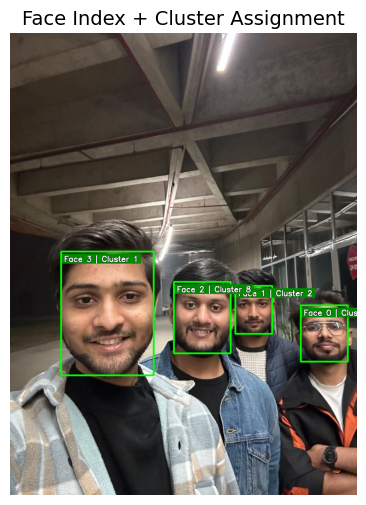

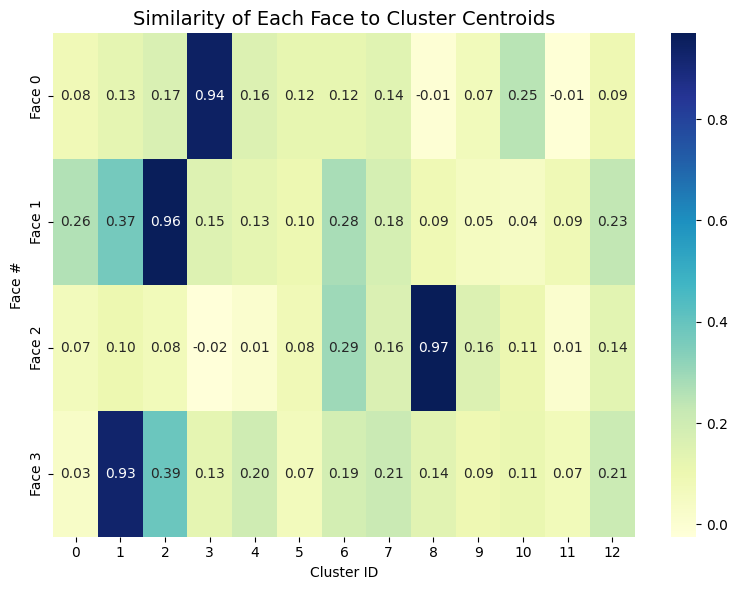

In [52]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# SELECT TARGET IMAGE
# ============================================================

TARGET_FILENAME = "WhatsApp Image 2025-11-27 at 21.13.26 (3).jpeg"

# ============================================================
# EXTRACT ALL FACES FROM SELECTED IMAGE
# ============================================================

faces_this_image = []
actual_path = None

for info, label in zip(face_infos, labels):
    if os.path.basename(info["img_path"]) == TARGET_FILENAME:
        faces_this_image.append({
            "embedding": info["embedding"],
            "bbox": info["bbox"],
            "cluster": label
        })
        actual_path = info["img_path"]

if actual_path is None:
    raise ValueError("Image not found. Check filename EXACTLY.")

img = cv2.imread(actual_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ============================================================
# GRAPH 2 — FACE INDEX + CLUSTER NAME (SUPER NEAT LABEL INSIDE BOX)
# ============================================================

plt.figure(figsize=(12,6))
vis2 = img_rgb.copy()

for i, f in enumerate(faces_this_image):
    x1, y1, x2, y2 = f["bbox"]
    cl = f["cluster"]

    # Label text
    label_text = f"Face {i} | Cluster {cl}"

    # Draw GREEN bounding box
    cv2.rectangle(vis2, (x1, y1), (x2, y2), (0,255,0), 3)

    # Label coordinates (inside the box)
    text_x = x1 + 8
    text_y = y1 + 28

    # Text size for background
    (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

    # Solid dark-green label background (clean & readable)
    cv2.rectangle(
        vis2,
        (text_x - 5, text_y - th - 5),
        (text_x + tw + 5, text_y + 5),
        (0,140,0),   # Dark green
        -1
    )

    # Text outline (black)
    cv2.putText(vis2, label_text, (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 4)

    # Text (white) — super readable
    cv2.putText(vis2, label_text, (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

plt.imshow(vis2)
plt.title("Face Index + Cluster Assignment", fontsize=14)
plt.axis("off")
plt.show()

# ============================================================
# GRAPH 3 — SIMILARITY OF EACH FACE TO ALL CLUSTER CENTROIDS
# ============================================================

# Build cluster centroids (ignore noise = -1)
unique_clusters = sorted(list(set(labels)))
cluster_centroids = {}

for cid in unique_clusters:
    if cid == -1:
        continue
    cluster_embs = np.vstack([
        info["embedding"]
        for info, lab in zip(face_infos, labels)
        if lab == cid
    ])
    cluster_centroids[cid] = cluster_embs.mean(axis=0)

# Build similarity table
similarity_table = []
for f in faces_this_image:
    row = {}
    for cid, centroid in cluster_centroids.items():
        sim = cosine_similarity(
            f["embedding"].reshape(1,-1),
            centroid.reshape(1,-1)
        )[0][0]
        row[cid] = sim
    similarity_table.append(row)

# Convert to DataFrame
df = pd.DataFrame(similarity_table)
df.index = [f"Face {i}" for i in range(len(faces_this_image))]

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Similarity of Each Face to Cluster Centroids", fontsize=14)
plt.xlabel("Cluster ID")
plt.ylabel("Face #")
plt.tight_layout()
plt.show()


In [53]:
import os

# Define allowed image extensions
IMAGE_EXT = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp'}

def count_images(folder_path, recursive=False):
    count = 0

    if recursive:
        # Walk through all subfolders
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if os.path.splitext(file)[1].lower() in IMAGE_EXT:
                    count += 1
    else:
        # Only count images in the top-level folder
        for file in os.listdir(folder_path):
            if os.path.isfile(os.path.join(folder_path, file)):
                if os.path.splitext(file)[1].lower() in IMAGE_EXT:
                    count += 1

    return count

# -------- USER INPUT --------
folder1 = "/Users/pranjalgarg/Desktop/test_image_recogo/dataset"   # Only images
folder2 = "/Users/pranjalgarg/Desktop/test_image_recogo/arcface_clusters_export"   # Contains subfolders

# -------- RESULTS --------
count1 = count_images(folder1, recursive=False)
count2 = count_images(folder2, recursive=True)

print(f" total images: {count1}")
print(f"Folder 2 total images (including subfolders): {count2}")


Folder 1 total images: 30
Folder 2 total images (including subfolders): 50


In [56]:
import os

IMAGE_EXT = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp'}

def count_images_in_folder(folder_path):
    """Count only images directly inside a folder (no recursion)."""
    count = 0
    for file in os.listdir(folder_path):
        full_path = os.path.join(folder_path, file)
        if os.path.isfile(full_path):
            if os.path.splitext(file)[1].lower() in IMAGE_EXT:
                count += 1
    return count


def count_images_with_subfolders(folder_path):
    """Count all images inside folder + give individual counts for subfolders."""
    total_images = 0
    subfolder_counts = {}

    for root, dirs, files in os.walk(folder_path):
        # Count images in the current directory
        image_count = sum(
            1 for f in files if os.path.splitext(f)[1].lower() in IMAGE_EXT
        )

        # Add to overall total
        total_images += image_count

        # If this root is a subfolder of the main folder → record it
        if root != folder_path:
            subfolder_name = os.path.basename(root)
            subfolder_counts[subfolder_name] = image_count

    return total_images, subfolder_counts


# -------------------- USER INPUT --------------------
folder1 = "/Users/pranjalgarg/Desktop/test_image_recogo/dataset"   # Only images
folder2 = "/Users/pranjalgarg/Desktop/test_image_recogo/arcface_clusters_export"   # Contains subfolders

# -------------------- RESULTS ------------------------
folder1_images = count_images_in_folder(folder1)

folder2_total, folder2_subcounts = count_images_with_subfolders(folder2)

print("===== Before Clustering =====")
print(f"Total images in before clustering : {folder1_images}\n")

print("===== After Clustering =====")
print(f"Total images (including all subfolders) after clustering : {folder2_total}")
print(f"Subfolder count: {len(folder2_subcounts)}\n")

print("Images per subfolder:")
for sub, count in folder2_subcounts.items():
    print(f" - {sub}: {count} images")


===== Before Clustering =====
Total images in before clustering : 30

===== After Clustering =====
Total images (including all subfolders) after clustering : 50
Subfolder count: 14

Images per subfolder:
 - cluster_8: 2 images
 - cluster_6: 3 images
 - cluster_1: 7 images
 - cluster_0: 4 images
 - cluster_7: 3 images
 - cluster_9: 4 images
 - cluster_10: 5 images
 - cluster_11: 2 images
 - noise: 10 images
 - cluster_2: 2 images
 - cluster_5: 2 images
 - cluster_4: 2 images
 - cluster_3: 2 images
 - cluster_12: 2 images
